<a href="https://colab.research.google.com/github/thefenriswolf/ML/blob/master/PROSTATA_CNN_transferlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import all nececessary Libaries
## tensorflow
The tensorflow machine learning toolkit, explicitly set to the latest version.
## keras
Keras is a high level API for tensorflow and makes complex underlying features available as higher level functions.
## os
A python module to interface with the underlying filesystem.
## numpy
A python libary for working with matrices in n-Dimensions.
## matplotlib
A python libary for plotting and graphing.

In [0]:
%tensorflow_version 2.x 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import matplotlib.pyplot as plt

# check for active GPU
tf.test.gpu_device_name()

TensorFlow 2.x selected.


'/device:GPU:0'

Set up some hardlinks to folders and count files in those folders.

In [0]:
train_dir = 'drive/My Drive/PROSTATE-DIAGNOSIS/train/'
test_dir = 'drive/My Drive/PROSTATE-DIAGNOSIS/test/'
backup_dir = 'drive/My Drive/models/'

pos_train_dir = os.path.join(train_dir, 'pos')
neg_train_dir = os.path.join(train_dir, 'neg')
pos_test_dir = os.path.join(test_dir, 'pos')
neg_test_dir = os.path.join(test_dir, 'neg')

num_pos_tr = len(os.listdir(pos_train_dir))
num_neg_tr = len(os.listdir(neg_train_dir))
num_pos_val = len(os.listdir(pos_test_dir))
num_neg_val = len(os.listdir(neg_test_dir))

total_train = num_pos_tr + num_neg_tr
total_val = num_pos_val + num_neg_val
total_train = num_pos_tr + num_neg_tr

print('total positive training images:', num_pos_tr)
print('total negative training images:', num_neg_tr)
print('total positive test images:', num_pos_val)
print('total negative test images:', num_neg_val)
print("-+-+-+-+-")
print("Total training images:", total_train)
print("Total test images:", total_val)

total positive training images: 11210
total negative training images: 1840
total positive test images: 3108
total negative test images: 226
-+-+-+-+-
Total training images: 13050
Total test images: 3334


In [0]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 160
IMG_WIDTH = 160
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)


train_image_generator = ImageDataGenerator(rescale=1./255, 
                                           rotation_range=6,
                                           #horizontal_flip=True,
                                           vertical_flip=True,
                                           zoom_range=0.3)

test_image_generator = ImageDataGenerator(rescale=1./255)

print("Train:")
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary',
                                                           interpolation='nearest')
print("Test")
test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=test_dir,
                                                              shuffle=True,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary',
                                                              interpolation='nearest')

Train:
Found 13050 images belonging to 2 classes.
Test
Found 3334 images belonging to 2 classes.


`tf.keras.models.load_model` restores a trained model from a HDF5 file.

In [0]:
#restore previously trained model

restored_model = tf.keras.models.load_model('drive/My Drive/models/cnn_revX.h5')
restored_model.summary()

## Base Model
I use `MobileNetV2` for transfer learning. `tf.keras.applications.MobileNetV2` loads the model and I then set the first 100 Layers to be trainable and the rest remains frozen.
## Global Average Layer


In [0]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

#base_model.trainable = False # dont train base model
base_model.trainable = True # make base model trainable

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer in the base model onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


#base_model.summary()
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)


9412608/9406464 [==============================] - 2s 0us/step
Number of layers in the base model:  155


In [0]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,863,873
Non-trainable params: 395,392
_________________________________________________________________


In [0]:
history = model.fit(train_data_gen,
                    epochs=15,
                    validation_data=test_data_gen,
                    verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 102 steps, validate for 27 steps
Epoch 1/15
102/102 [==============================] - 15873s 156s/step - loss: 0.3097 - accuracy: 0.8762 - val_loss: 0.3540 - val_accuracy: 0.9319
Epoch 2/15
102/102 [==============================] - 133s 1s/step - loss: 0.1679 - accuracy: 0.9379 - val_loss: 0.3665 - val_accuracy: 0.8932
Epoch 3/15
102/102 [==============================] - 133s 1s/step - loss: 0.1165 - accuracy: 0.9546 - val_loss: 0.3710 - val_accuracy: 0.8800
Epoch 4/15
102/102 [==============================] - 134s 1s/step - loss: 0.0873 - accuracy: 0.9644 - val_loss: 0.6566 - val_accuracy: 0.6866
Epoch 5/15
102/102 [==============================] - 133s 1s/step - loss: 0.0667 - accuracy: 0.9742 - val_loss: 1.1979 - val_accuracy: 0.5540
Epoch 6/15
102/102 [==============================] - 133s 1s/step - loss: 0.0584 - accuracy: 0.9792 - val_loss: 0.7114 - val_accuracy: 0.7409
Epoch 7/15
102/102 [=========================

In [0]:
# Save model as HDF5
model.save('drive/My Drive/models/cnn_revX.h5')

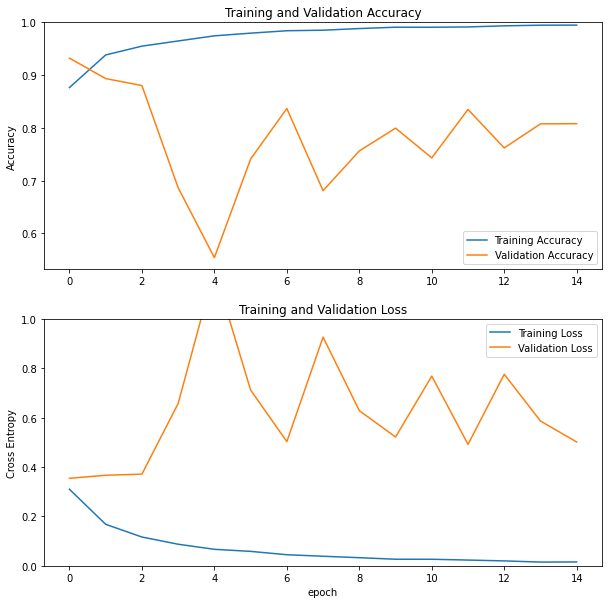

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


MIT License

Copyright (c) 2017 François Chollet

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.